# Escalamiento de datos numéricos

## Transformaciones líneales

In [183]:
import timeit # medir el performance de modelos ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

X, y = datasets.load_diabetes(return_X_y=True)
# Xdf, ydf = datasets.load_diabetes(return_X_y=True, as_frame=True)
# Transformacion de las dimensiones para que se ajute al formato de entrada del pre-procesamiento
raw = X[:, None, 2]
# print(X.shape)
# Xdf

Documentación del dataset [diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html).

### Reglas de escalamiento P1

- `min-max`: Mejor para datos uniformemente distribuidos <br>
Formula: $$x_s = \frac {2x - min - max}{max - min}$$


In [184]:
min_raw = min(raw)
max_raw = max(raw)
scaled = (2 * raw - min_raw - max_raw) / (max_raw - min_raw)
# scaled

> 📌 **NOTA**: Antes de aplicar una regla de escalamiento primero debemos tener una noción de como estan distribuidos los datos que vamos a escalar.

Comparación de la distribución de los datos 
- Originales vs Escalados

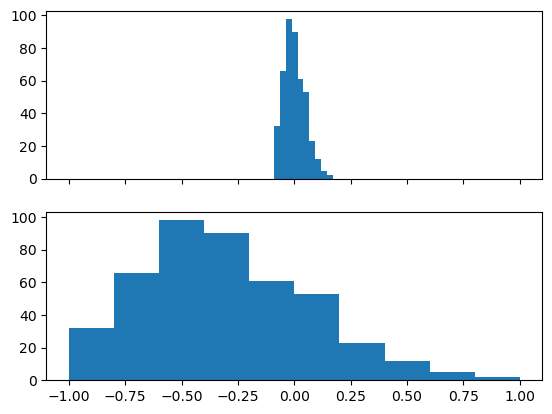

In [222]:
fig, (orig, scal) = plt.subplots(nrows=2, ncols=1, sharex=True)
# Con sharex compartimos el mismo eje en x en ambos graficos,
# esto ayuda a apreciar el ejecto del escalamiento
orig.hist(raw)
scal.hist(scaled)
plt.show()

#### Modelos para entrenamiento

Una vez el dataset este escalado, pasamos al entrenamiento del modelo.

In [186]:
# Entrenamiento con los datos no escalados
def train_raw():
  linear_model.LinearRegression().fit(raw, y)

# Entrenamiento con los datos escalados
def train_scaled():
  linear_model.LinearRegression().fit(scaled, y)

In [187]:
# Calcular el tiempo de ejecución del modelo, 
# Originales vs Escalados

raw_time = timeit.timeit(train_raw, number=100)
scaled_time = timeit.timeit(train_scaled, number=100)

print(f"Tiempo en con los datos originales: {raw_time}")
print(f"Tiempo en los datos escalados: {scaled_time}")

Tiempo en con los datos originales: 0.10072954699717229
Tiempo en los datos escalados: 0.06786024100074428


### Reglas de escalamiento P2

- `z-score`: Mejor para datos distribuidos "normalmente" (forma de campana de gauss) <br>
Formula: $$x_s = \frac {x - \text{\=X}}{\sigma}$$

In [188]:
mean = np.mean(raw)
std = np.std(raw)
print(f"media: {mean}, desv. estandar: {std}")

z_scaled = (raw - mean) / std

media: -2.2455642172282577e-16, desv. estandar: 0.0475651494154494


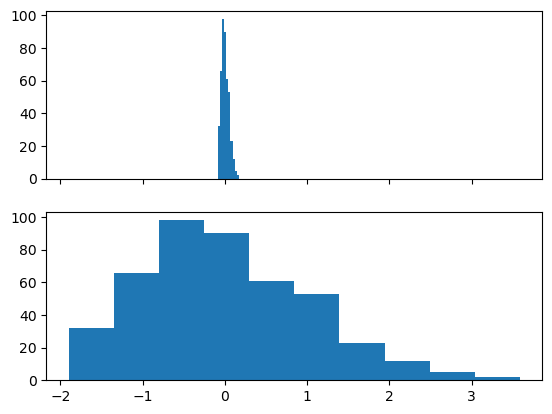

In [221]:
fig, (orig_raw, z_scal) = plt.subplots(nrows=2, ncols=1, sharex=True)
# Con sharex compartimos el mismo eje en x en ambos graficos,
# esto ayuda a apreciar el ejecto del escalamiento
orig_raw.hist(raw)
z_scal.hist(z_scaled)
plt.show()

#### Modelos para entrenamiento

In [190]:
def train_z():
  linear_model.LinearRegression().fit(z_scaled, y)

In [191]:
# Calcular el tiempo de ejecución del modelo, 
# Originales vs Escalados

raw_time = timeit.timeit(train_raw, number=100)
z_scaled_time = timeit.timeit(train_z, number=100)

print(f"Tiempo en con los datos originales: {raw_time}")
print(f"Tiempo en los datos escalados en z: {z_scaled_time}")

Tiempo en con los datos originales: 0.08586899299916695
Tiempo en los datos escalados en z: 0.07333587700122735


## Transformaciones no lineales

Estas transformaciones se realizan cundo los datos estan fuertemente sesgados. 

In [192]:
cars_df = pd.read_csv("../data/cars.csv")

Visualización de los precios de los autos:

<Axes: ylabel='Frequency'>

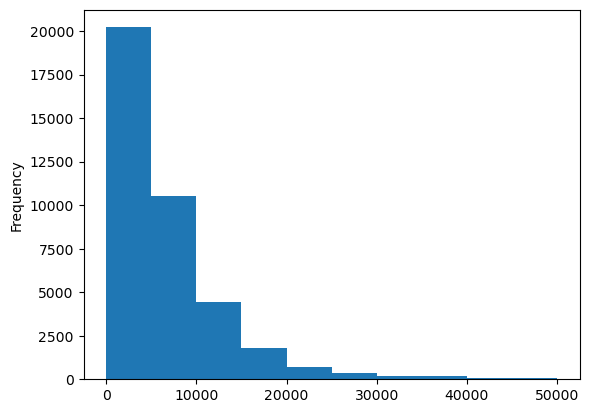

In [193]:
cars_df["price_usd"].plot.hist()

### Transformación manual con la función `tanh(x)`

<Axes: >

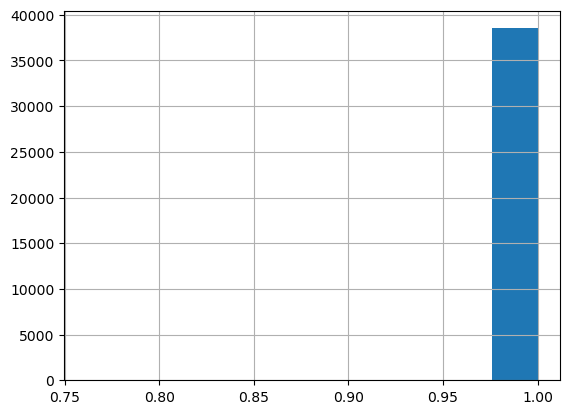

In [194]:
cars_df.price_usd.apply(lambda x: np.tanh(x)).hist()

La función `tanh` colapsó todos los datos a un solo valor, en este caso en 1. <br>
Para calibrar la transformación de los datos utilizaremos un factor `a` que divida a cada elemento que necesitamos transformar. 

In [202]:
def tanh_transformation(a, data):
  manual_trans = data.apply(lambda x: np.tanh(x/a))
  return manual_trans

<Axes: >

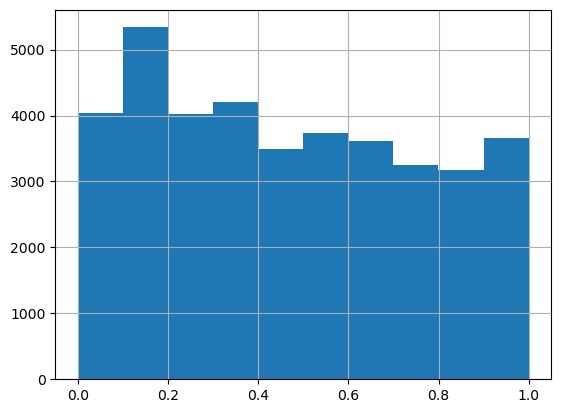

In [219]:
manual_trans = tanh_transformation(10000, cars_df.price_usd)
manual_trans.hist()

> 📌 **NOTA**: El valor asignado a la variable `a` lo vamos ajuntando dependiendo de la calibración a la que queramos llegar (simietrizar los datos).

### Transformación con PowerTransformer de la librería `sklearn`

Comparar los métodos de transformación
1. `Box-Cox`
2. `Yeo-Johnson`

Modificamos la forma del dataset con la columna a transformar. 

In [196]:
car_prices = cars_df["price_usd"].to_numpy().reshape((-1, 1))
car_prices.shape

(38531, 1)

In [197]:
bc = PowerTransformer("box-cox")
yj = PowerTransformer("yeo-johnson")

Transformaciones con `PowerTransformer` y `train_test_split`

In [223]:
# Los métodos de transformación box-cox y yeo-johnson 
# necesitan que la estructura de los datos sea de  2D
reshaped_prices = cars_df.price_usd.to_numpy().reshape(-1,1)
price_train, price_test = train_test_split(reshaped_prices)

# Box-Cox
price_trans_bc = bc.fit(price_train).transform(price_test)
# Yeo-Johnson
price_trans_yj = yj.fit(price_train).transform(price_test)

Visualización de las diferentes transformaciones

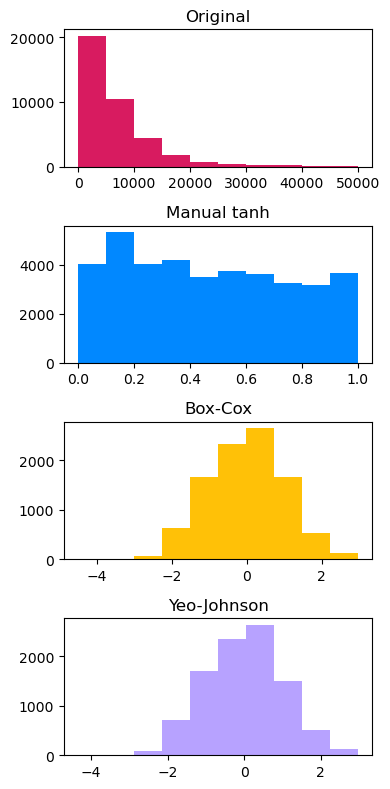

In [224]:
# Lista de que contiene el título del método utilizado y la data transformada.
distributions = [
  ("Original", cars_df.price_usd),
  ("Manual tanh", manual_trans),
  ("Box-Cox", price_trans_bc),
  ("Yeo-Johnson", price_trans_yj)
]

# Lista de colores para cada gráfica
colors = ["#D81B60", "#0188FF", "#FFC107", "#B7A2FF"]

fig, axes = plt.subplots(nrows=len(distributions), ncols=1, figsize=plt.figaspect(2))

for distribution, color, ax in zip(distributions, colors, axes):
  name, X = distribution  
  ax.set_title(name)
  ax.hist(X, color=color)

fig.tight_layout()


Escalamiento `z-score` de los datos transformados con el método `Box-Cox`

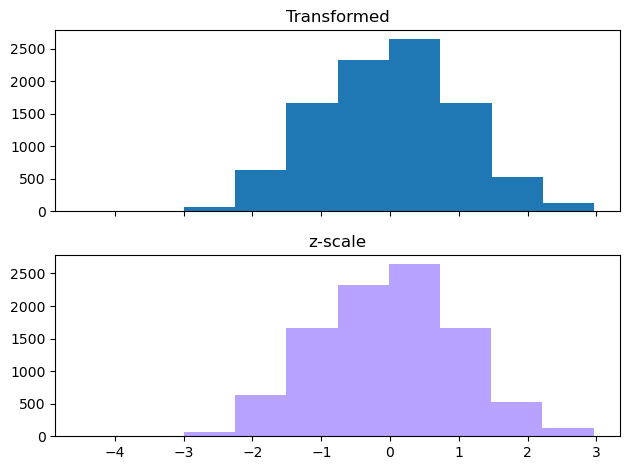

In [231]:
mean_bc_trans = price_trans_bc.mean()
std_bc_trans = price_trans_bc.std()

z_scaled_bc_trans = (price_trans_bc - mean_bc_trans) / std_bc_trans

fig, (trans, scaled) = plt.subplots(nrows=2, ncols=1, sharex=True)

trans.set_title("Transformed")
trans.hist(price_trans_bc)

scaled.set_title("z-scale")
scaled.hist(z_scaled_bc_trans, color="#B7A2FF")

fig.tight_layout()